# Fashion Dataset 
https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small/data

The growing e-commerce industry presents us with a large dataset waiting to be scraped and researched upon. In addition to professionally shot high resolution product images, the dataset includes multiple label attributes describing the product which was manually entered while cataloging. 

Each product is identified by an ID like 42431. A map to all the products in styles.csv. From here, you can fetch the image for this product from images/42431.jpg. This will serve as the label for ourusecase.

Our task here would be to classify the products into their masterCategory which are Accessories', 'Apparel', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods', 'Home' and 'Cosmetics'

## Data Preprocessing

In [9]:
# Loading the CSV file
import pandas as pd
import os
import cv2

csv_file_path = 'archive/styles.csv'
csv_data = pd.read_csv(csv_file_path)
csv_data.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt

In [10]:
# Stats of the CSV file
csv_data.describe()

id          year
count  44446.000000  44445.000000
mean   29692.631350   2012.805940
std    17048.234982      2.126401
min     1163.000000   2007.000000
25%    14770.250000   2011.000000
50%    28609.500000   2012.000000
75%    44678.750000   2015.000000
max    60000.000000   2019.000000

There are around 44.4k images. To keep the running time in check we will subsample the data and do further analysis.

In [11]:
# Check for null values in the DataFrame
null_values = csv_data.isnull().sum()

print("Null values per column:")
print(null_values)

Null values per column:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64


In [12]:
# Removing all null values

csv_data = csv_data.dropna()

null_values = csv_data.isnull().sum()

print("Null values per column:")
print(null_values)

Null values per column:
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64


Since we already have a lot of images and will subsample the data, removed the rows with atleast 1 null value.

In [13]:
csv_data.describe()

id          year
count  44099.000000  44099.000000
mean   29546.918071   2012.781492
std    16972.968257      2.108042
min     1163.000000   2007.000000
25%    14723.500000   2011.000000
50%    28477.000000   2012.000000
75%    44402.500000   2015.000000
max    60000.000000   2019.000000

Around 44K instances, will be subsampling by 10 around 4.4K samples.

In [14]:
# Subsample

csv_data = csv_data.sample(frac=1, random_state=42)  

subsample_fraction = 0.1
subsampled_data = csv_data.sample(frac=subsample_fraction, random_state=42)

subsampled_data.describe()

id         year
count   4410.000000  4410.000000
mean   29612.752834  2012.788662
std    17031.122055     2.120172
min     1538.000000  2007.000000
25%    14435.250000  2011.000000
50%    28512.500000  2012.000000
75%    44918.750000  2015.000000
max    59987.000000  2019.000000

Randomised and subsampled to 4.4K sample for faster runtimes.

In [15]:
# Find distinct values for the specified attributes
distinct_master_category = subsampled_data['masterCategory'].unique()
distinct_gender = subsampled_data['gender'].unique()
distinct_subcategory = subsampled_data['subCategory'].unique()
distinct_article_type = subsampled_data['articleType'].unique()
distinct_season = subsampled_data['season'].unique()

print("Distinct values for masterCategory:", distinct_master_category)
print("Distinct values for gender:", distinct_gender)
print("Distinct values for subCategory:", distinct_subcategory)
print("Distinct values for articleType:", distinct_article_type)
print("Distinct values for season:", distinct_season)

Distinct values for masterCategory: ['Accessories' 'Apparel' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
Distinct values for gender: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
Distinct values for subCategory: ['Watches' 'Eyewear' 'Topwear' 'Bottomwear' 'Shoes'
 'Loungewear and Nightwear' 'Socks' 'Bags' 'Fragrance' 'Innerwear'
 'Sandal' 'Headwear' 'Apparel Set' 'Lips' 'Dress' 'Wallets' 'Belts'
 'Scarves' 'Ties' 'Jewellery' 'Cufflinks' 'Flip Flops' 'Makeup' 'Skin'
 'Eyes' 'Accessories' 'Saree' 'Gloves' 'Nails' 'Stoles' 'Perfumes'
 'Mufflers' 'Free Gifts' 'Skin Care' 'Hair' 'Wristbands' 'Bath and Body'
 'Home Furnishing' 'Sports Equipment']
Distinct values for articleType: ['Watches' 'Sunglasses' 'Jackets' 'Jeggings' 'Tshirts' 'Kurtas' 'Capris'
 'Casual Shoes' 'Churidar' 'Flats' 'Formal Shoes' 'Night suits'
 'Sweatshirts' 'Track Pants' 'Sweaters' 'Socks' 'Handbags' 'Deodorant'
 'Boxers' 'Shirts' 'Nightdress' 'Sports Shoes' 'Sandals' 'Briefs' 'Caps'
 'Kurta Sets' 'Lipsti

In [18]:
# Constructing labels out of the CSV file for the subsampled images

import shutil

# Specify the paths to the source and destination folders
source_folder = 'archive/images/'
destination_folder = 'archive/images_subsampled/'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

labels = []
label_category = []

# Iterate through the rows of the DataFrame
for index, row in subsampled_data.iterrows():
    # Extract the ID from the 'id' column
    image_id = str(row['id'])
    master_category = str(row['masterCategory'])
    
    # Construct the file name (assuming it's id.jpg)
    image_filename = f"{image_id}.jpg"
    
    # Check if the image file exists in the source folder
    source_image_path = os.path.join(source_folder, image_filename)
    
    if os.path.exists(source_image_path):
        # Copy the image to the destination folder
        destination_image_path = os.path.join(destination_folder, image_filename)
        shutil.copyfile(source_image_path, destination_image_path)
        label_category.append(master_category)
        if master_category == 'Accessories':
            labels.append(0)
        elif master_category == 'Apparel':
            labels.append(1)
        elif master_category == 'Footwear':
            labels.append(2)
        elif master_category == 'Personal Care':
            labels.append(3)
        elif master_category == 'Free Items':
            labels.append(4)
        elif master_category == 'Sporting Goods':
            labels.append(5)
        else:
            labels.append(6)

# Specify the file path where you want to save the label_category
file_path = 'label_category.txt'  # Replace with your actual file path

# Write each element of the list to a separate line in the file
with open(file_path, 'w') as file:
    for category in label_category:
        file.write(f"{category}\n")

print(f"Label categories have been saved to {file_path}")


Label categories have been saved to label_category.txt


In [20]:
# Loading the subsampled images

input_folder = 'archive/images_subsampled/'
output_folder = 'archive/images_subsampled_gray/'
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        output_path = os.path.join(output_folder, f"gray_{filename}")
        cv2.imwrite(output_path, gray_img)

Now the CSV data and image data are subsampled, cleaned and ready to be used.\
However we do not have the labels yet.\
The labels need to be extracted from the CSV file whose ID is mapping to the filename of the image.

## Dimensionality Reduction

### Q1 
### a. Applying PCA
### b. Number of components required to preserve 95% variance 

In [90]:
# Q1 
# a. Applying PCA
# b. Number of components required to preserve 95% variance 

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

selected_images_folder = 'archive/images_subsampled_gray'

target_size = (100, 100)  

image_data = []
image_list = []

for filename in os.listdir(selected_images_folder):
    image_path = os.path.join(selected_images_folder, filename)
    
    with Image.open(image_path) as img:
        img_resized = img.resize(target_size)
        img_array = np.array(img_resized).flatten()
        image_data.append(img_array)
        if img_resized is not None:
            image_list.append(img_resized)

image_data = np.array(image_data)

# Standardize the image data 
scaler = StandardScaler()
image_data_standardized = scaler.fit_transform(image_data)

# a. Apply PCA
pca = PCA()
image_data_pca = pca.fit_transform(image_data_standardized)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# b. Find the number of components needed for 95% variance
target_variance = 0.95
num_components_95 = np.argmax(cumulative_variance_ratio >= target_variance) + 1

print(f"Number of components to preserve {target_variance * 100}% of variance: {num_components_95}")

Number of components to preserve 95.0% of variance: 305


305 components / dimensions are required to preserve 95% of the variance

### Q2
### a. 10 images in their original form - here by original for the image is preprocessed but no dimensionality techniques are applied on it.
### b. 10 images in their reconstructed form

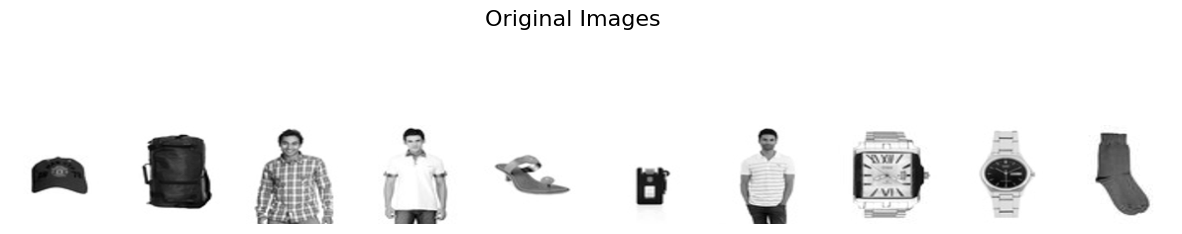

In [203]:
# Q2
# a. 10 images in their original form - here by original for the image is preprocessed but no dimensionality techniques are applied on it.
# b. 10 images in their reconstructed form

import matplotlib.pyplot as plt

# Apply PCA
pca_95 = PCA(n_components=305)  
image_data_pca_95 = pca_95.fit_transform(image_data_standardized)

# Inverse transform to get the projected data back to the original space
image_data_reconstructed = pca_95.inverse_transform(image_data_pca_95)

plt.figure(figsize=(15, 6))
plt.suptitle('Original Images', fontsize=16)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_data[i].reshape(target_size), cmap='gray')
    plt.axis('off')

plt.show()

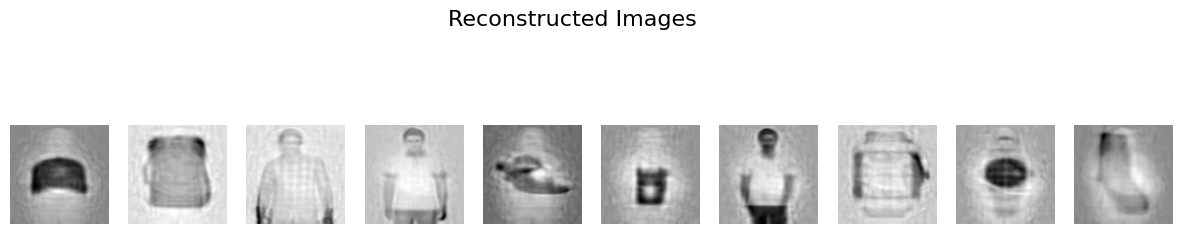

In [207]:
# Reconstructed images

plt.figure(figsize=(15, 6))
plt.suptitle('Reconstructed Images', fontsize=16)
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(image_data_reconstructed[i].reshape(target_size), cmap='gray')
    plt.axis('off')

plt.show()

### Q3.A
### a. Apply PCA with 2 dimensions 
### b. How much variance is preserved with these 2 components

In [92]:
# Q3.A
# a. Apply PCA with 2 dimensions 
# b. How much variance is preserved with these 2 components

# Apply PCA with 2 components
pca_2 = PCA(n_components=2)
image_data_pca_2 = pca_2.fit_transform(image_data_standardized)

# Calculate the explained variance ratio for the first two components
explained_variance_ratio = pca_2.explained_variance_ratio_
total_variance_explained = np.sum(explained_variance_ratio)

print(f"Explained Variance with the first two components: {total_variance_explained * 100:.2f}%")

Explained Variance with the first two components: 32.26%


In [214]:
# Function to visualize images in 2D space
def visualize_2d_embedding(embedding, labels, title):
    plt.figure(figsize=(12, 8))
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(embedding[indices, 0], embedding[indices, 1], label=f'Category {label}', alpha=0.7)

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

### Q3.B
### Scatter plot after applying PCA - 
### i.Plain scatter plot    
### ii.Image visualisation along the scatter plot and    
### iii. Image with categorisation overlay

In [216]:
import pandas as pd

# Create a DataFrame for the mapping
category_mapping_df = pd.DataFrame({
    'Master Category': ['Accessories', 'Apparel', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods', 'Home'],
    'Label': [0, 1, 2, 3, 4, 5, 6]
})

# Example usage:
# Assuming you have a list of master categories, you can merge it with the mapping DataFrame
master_category_data = ['Accessories', 'Apparel', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods', 'Home']
master_category_df = pd.DataFrame({'Master Category': master_category_data})

# Merge with the mapping DataFrame
merged_df = pd.merge(master_category_df, category_mapping_df, on='Master Category', how='left')

# Display the resulting DataFrame
print(merged_df)


  Master Category  Label
0     Accessories      0
1         Apparel      1
2        Footwear      2
3   Personal Care      3
4      Free Items      4
5  Sporting Goods      5
6            Home      6


Please refer to this dataframe for the legends in the subsequent plots.\
(Was not able to put this in the plot due to syntactical reasons)

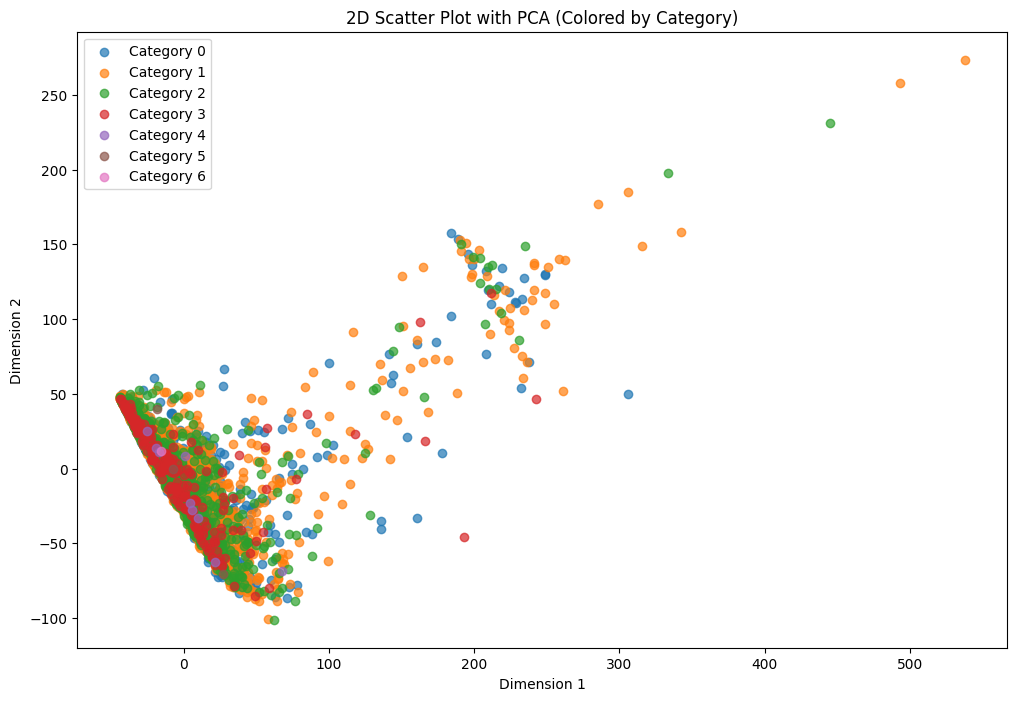

In [215]:
# Q3.B
# Scatter plot after applying PCA 
# Visualize PCA embedding
visualize_2d_embedding(image_data_pca_2, labels, '2D Scatter Plot with PCA (Colored by Category)')

In [110]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# function for scatter plot with images
def scatter_plot_with_images(embeddings, labels, image_list, title):
    plt.figure(figsize=(12, 8))

    for category in np.unique(labels):
        indices = labels == category
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=category)

    # Add product images to the plot
    ax = plt.gca()
    for i, label in enumerate(labels):
        if i < len(image_list):  # To ensure we have images for each point
            imagebox = OffsetImage(image_list[i], zoom=0.15)
            ab = AnnotationBbox(imagebox, (embeddings[i, 0], embeddings[i, 1]), frameon=False, pad=0)
            ax.add_artist(ab)

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

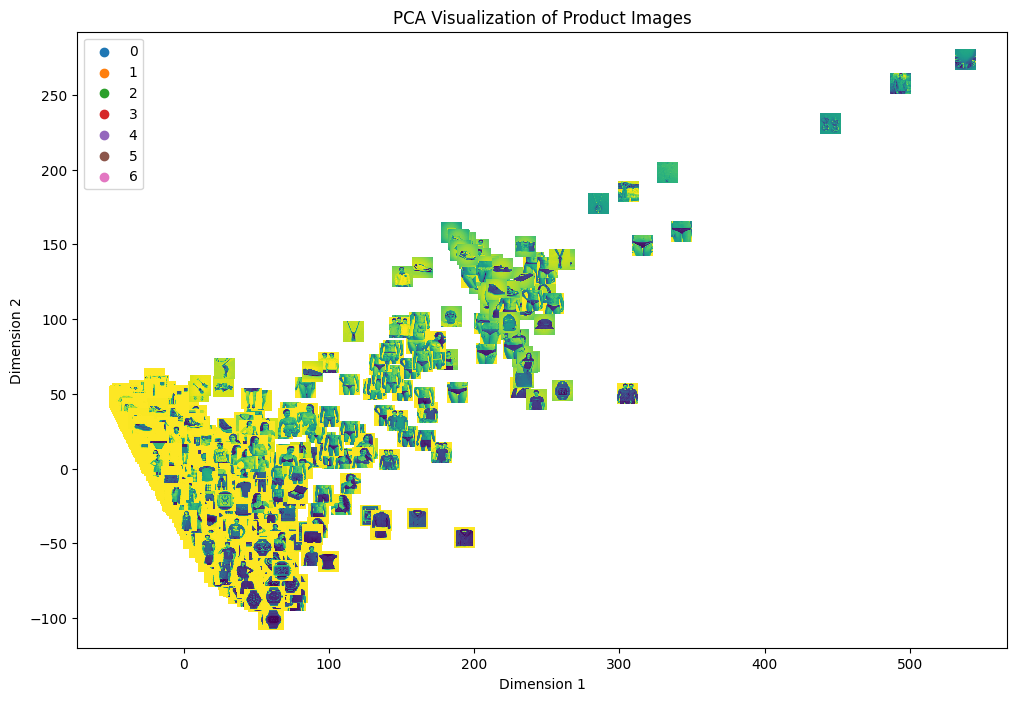

In [111]:
# Apply PCA
scatter_plot_with_images(image_data_pca_2, labels, image_list, 'PCA Visualization of Product Images')

In [112]:
def scatter_plot_and_overlayed_images(embeddings, labels, image_list, title, zoom=0.2):
    plt.figure(figsize=(14, 10))  # Increase the figure size

    # Scatter plot with images
    for i, label in enumerate(labels):
        if i < len(image_list):  # To ensure we have images for each point
            imagebox = OffsetImage(image_list[i], zoom=zoom)
            ab = AnnotationBbox(imagebox, (embeddings[i, 0], embeddings[i, 1]), frameon=False, pad=0)
            plt.gca().add_artist(ab)

    # Scatter plot without images
    for label in np.unique(labels):
        indices = np.where(labels == label)
        plt.scatter(embeddings[indices, 0], embeddings[indices, 1], label=f'Category {label}', alpha=0.7, zorder=10)  # Set zorder to ensure scatter plot is on top

    plt.title(title)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()

    # Show the combined plot
    plt.show()

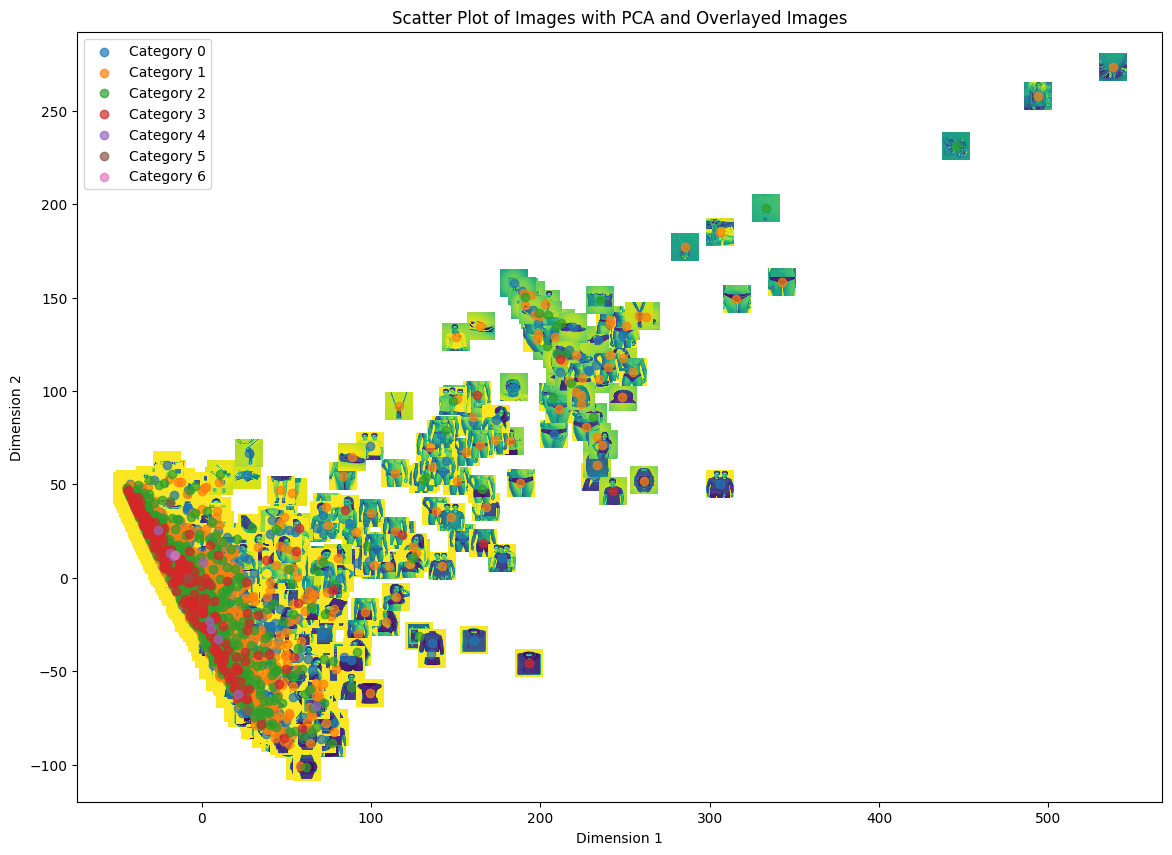

In [113]:
scatter_plot_and_overlayed_images(image_data_pca_2,labels,image_list,'Scatter Plot of Images with PCA and Overlayed Images')

### Q3.B
### a. Scatter plot after applying t-SNE - 
### i.Plain scatter plot    
### ii.Image visualisation along the scatter plot and    
### iii. Image with categorisation overlay

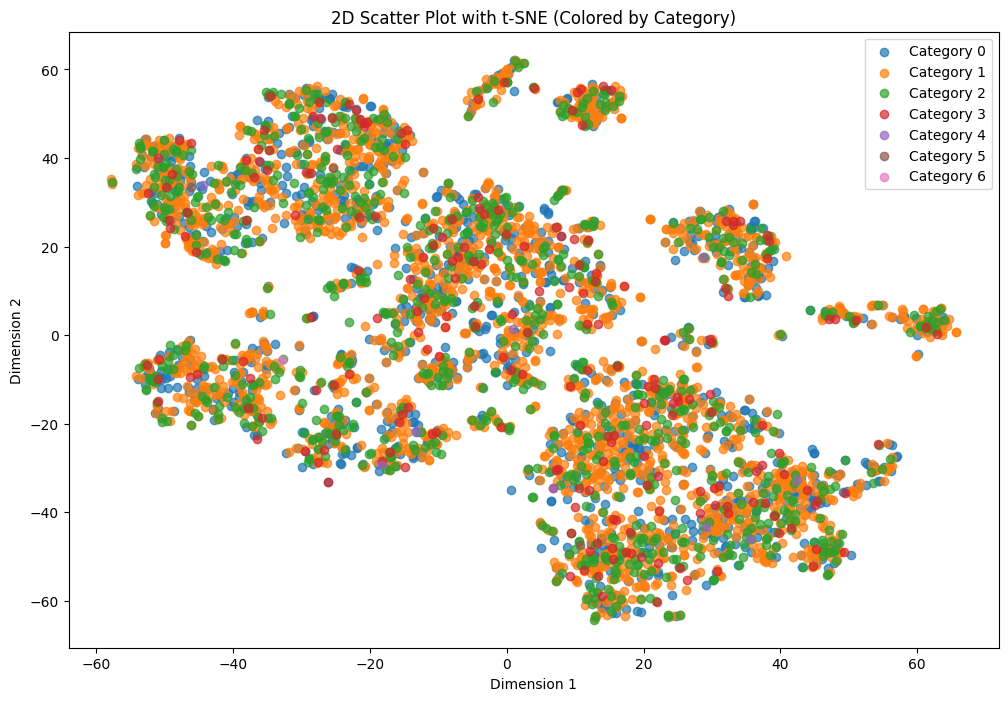

In [114]:
# Q3.B
# a. Scatter plot after applying t-SNE
# i. Plain scatter plot  

from sklearn.manifold import TSNE

# Apply t-SNE with 2 components
tsne = TSNE(n_components=2)
images_2d_tsne = tsne.fit_transform(image_data_standardized)

# Visualize t-SNE embedding
visualize_2d_embedding(images_2d_tsne, labels, '2D Scatter Plot with t-SNE (Colored by Category)')

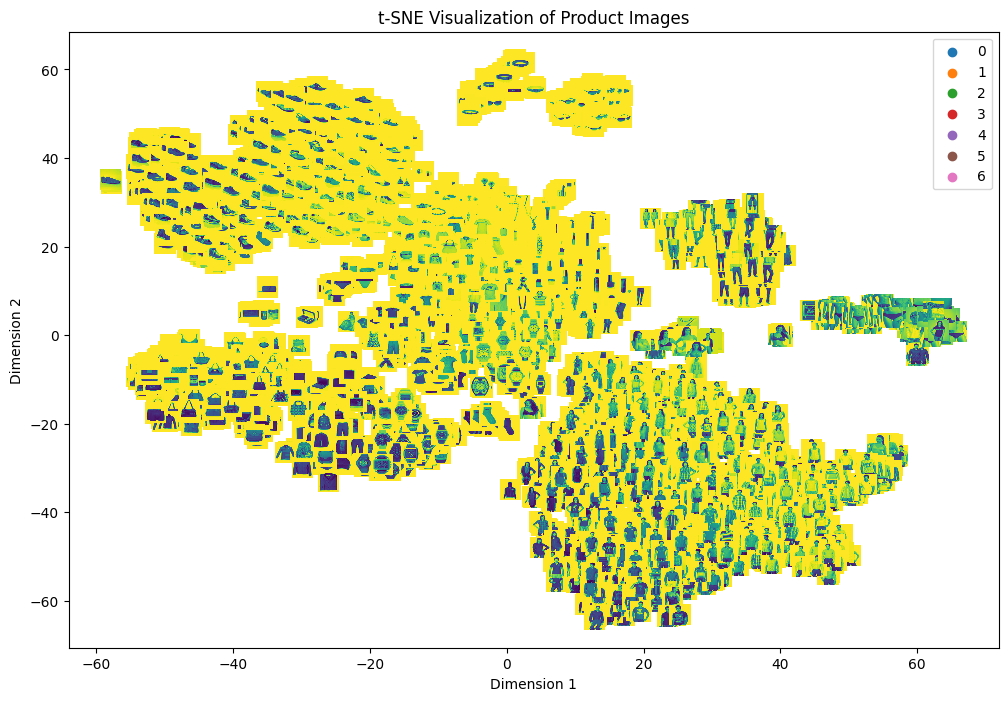

In [115]:
# ii. Image visualisation along the scatter plot

scatter_plot_with_images(images_2d_tsne, labels, image_list, 't-SNE Visualization of Product Images')

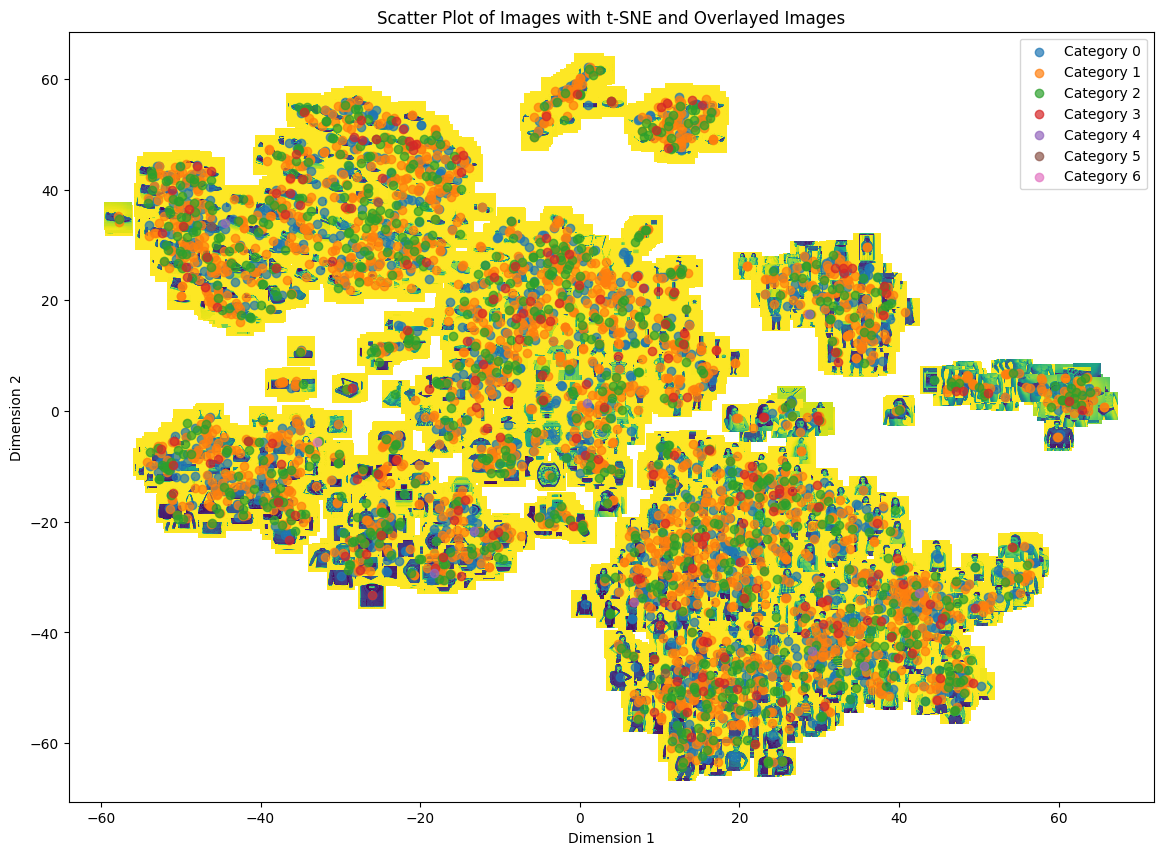

In [116]:
# iii. Image with categorisation overlay
scatter_plot_and_overlayed_images(images_2d_tsne, labels, image_list, 'Scatter Plot of Images with t-SNE and Overlayed Images')

### Q3.B
### b. Scatter plot after applying LLE - 
### i.Plain scatter plot    
### ii.Image visualisation along the scatter plot and    
### iii. Image with categorisation overlay

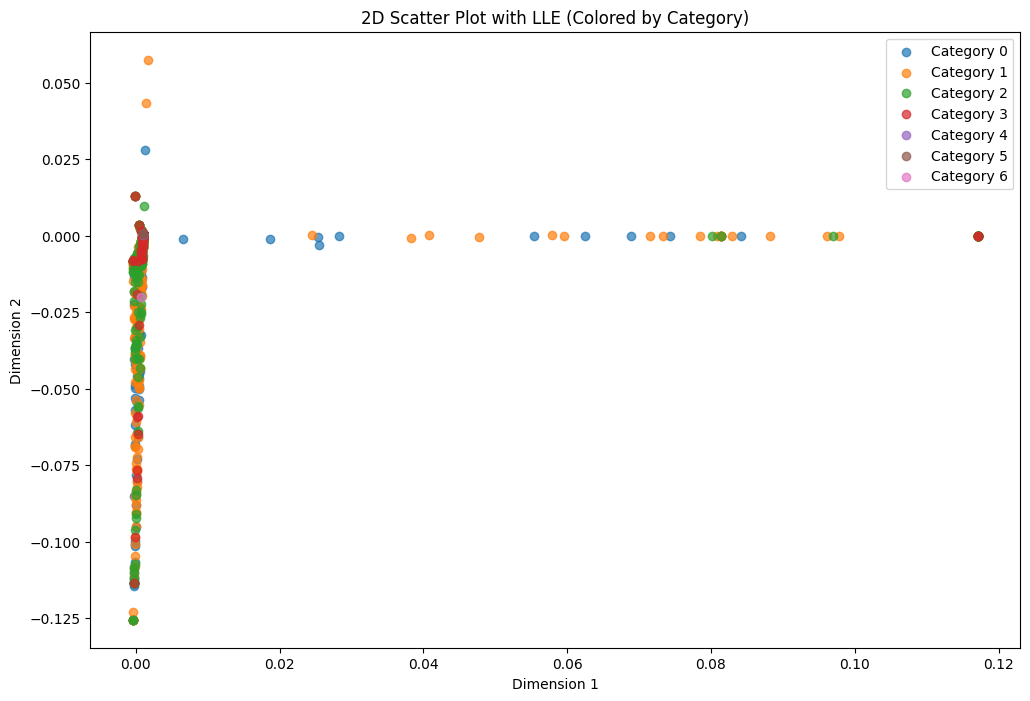

In [117]:
# Q3.B
# b. Scatter plot after applying LLE
# i. Plain scatter plot  

from sklearn.manifold import LocallyLinearEmbedding, MDS

# Apply LLE with 2 components
lle = LocallyLinearEmbedding(n_components=2)
images_2d_lle = lle.fit_transform(image_data_standardized)

# Visualize LLE embedding
visualize_2d_embedding(images_2d_lle, labels, '2D Scatter Plot with LLE (Colored by Category)')

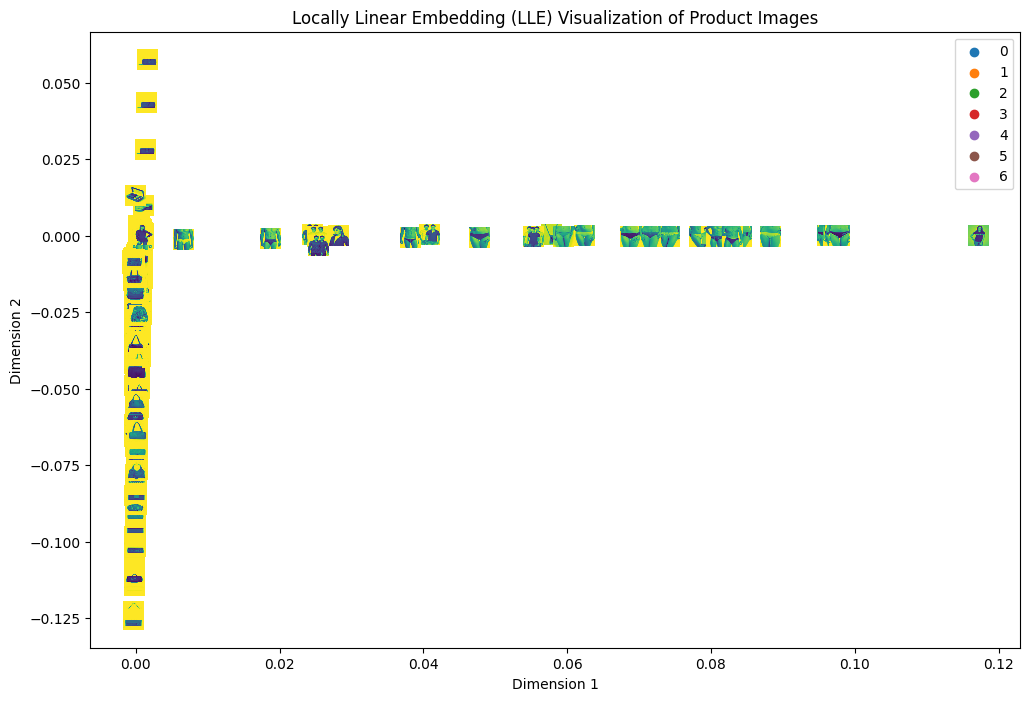

In [118]:
# ii. Image visualisation along the scatter plot
scatter_plot_with_images(images_2d_lle, labels, image_list, 'Locally Linear Embedding (LLE) Visualization of Product Images')

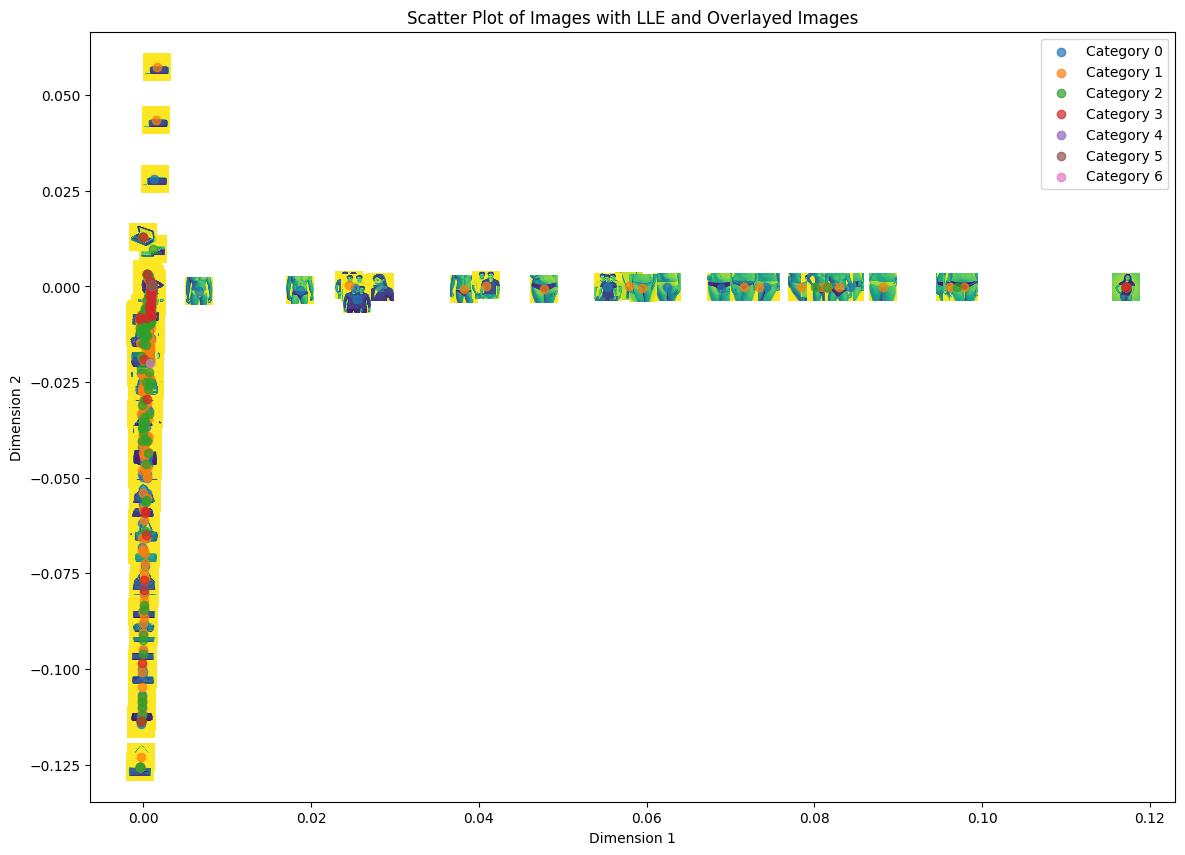

In [119]:
# iii. Image with categorisation overlay
scatter_plot_and_overlayed_images(images_2d_lle, labels, image_list, 'Scatter Plot of Images with LLE and Overlayed Images')

### Q3.B
### c. Scatter plot after applying MDS - 
### i.Plain scatter plot    
### ii.Image visualisation along the scatter plot and    
### iii. Image with categorisation overlay

/usr/local/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


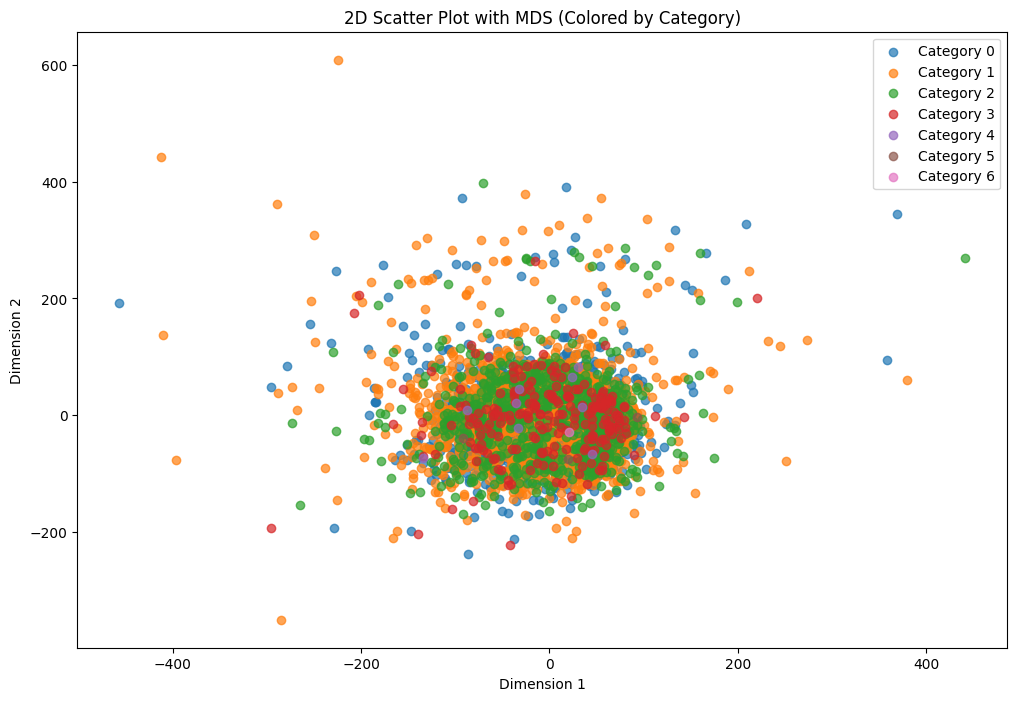

In [122]:
# Q3.B
# c. Scatter plot after applying MDS
# i. Plain scatter plot 

# Apply MDS with 2 components
mds = MDS(n_components=2)
images_2d_mds = mds.fit_transform(image_data_standardized)

# Visualize MDS embedding
visualize_2d_embedding(images_2d_mds, labels, '2D Scatter Plot with MDS (Colored by Category)')

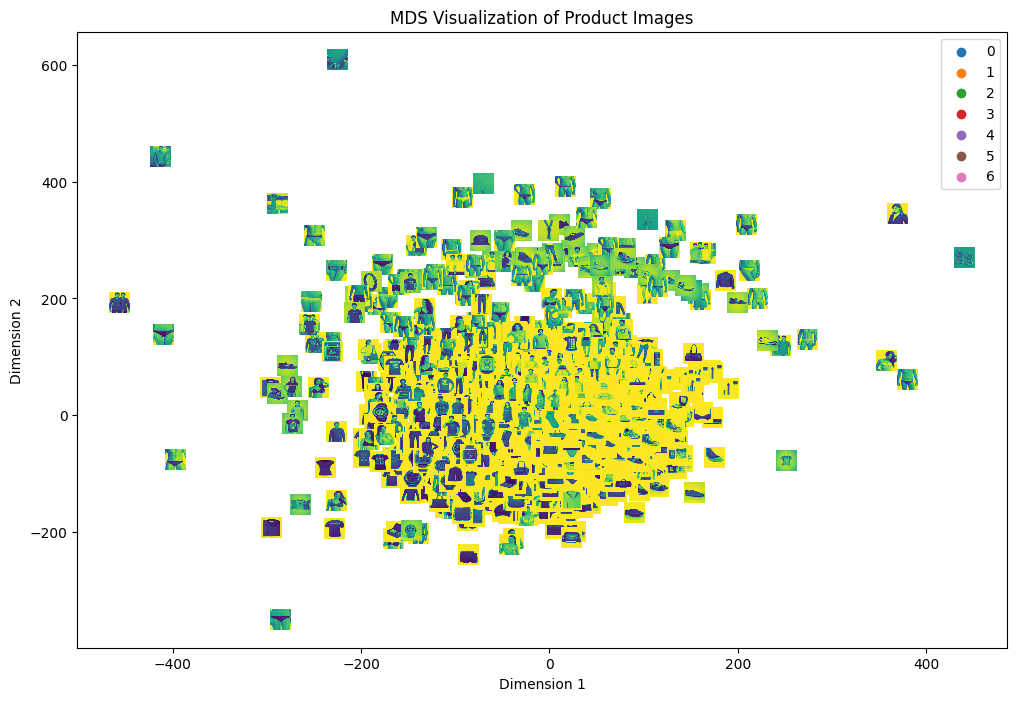

In [123]:
# ii. Image visualisation along the scatter plot

scatter_plot_with_images(images_2d_mds, labels, image_list, 'MDS Visualization of Product Images')

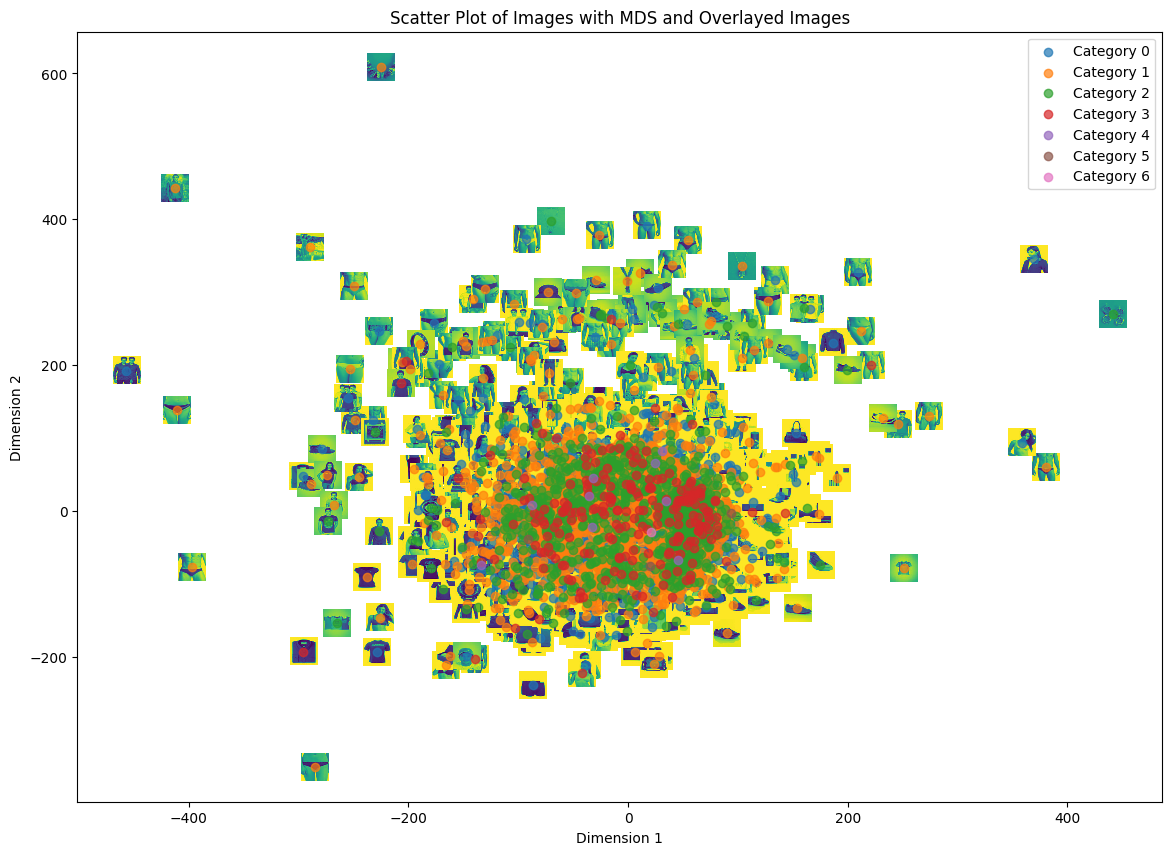

In [124]:
# iii. Image with categorisation overlay

scatter_plot_and_overlayed_images(images_2d_mds, labels, image_list, 'Scatter Plot of Images with MDS and Overlayed Images')

### Q3.C
### Discussion on the visualizations

From the methods given, after plotting the scatter plots of different kinds, the t-SNE method seems to be giving a better categorisation.\
The accessories seems to be clustered together and the Apparel together into another cluster.\
From the visualisation plots Image with categorisation overlay seems to be giving more detailed information.\
And the method and technique are my personal preferences.


# K-means Classification

### Q5.A
### a. K-means is applied with PCA reduced data set
### b. Selection of number of clusters using one of the techniques

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

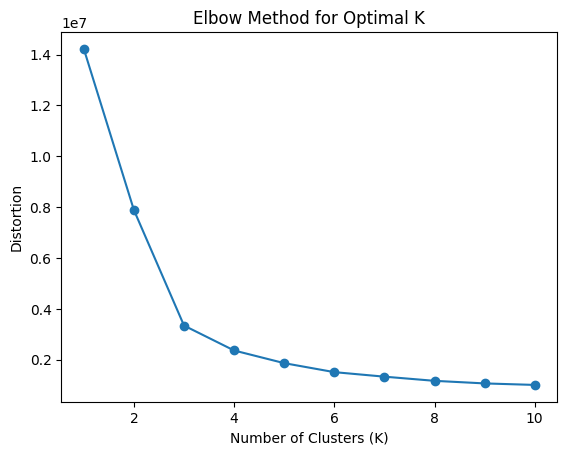

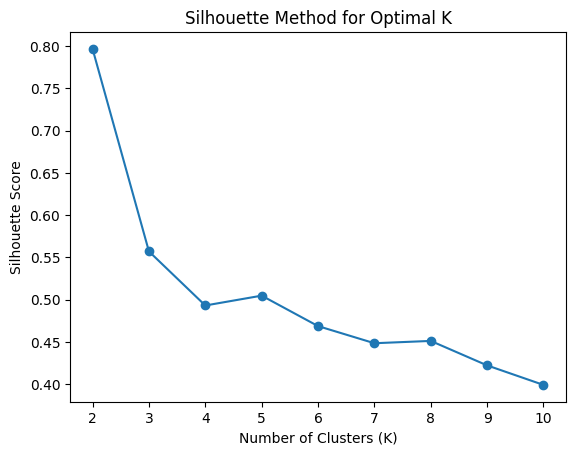

In [127]:
# Q5.A.
# a. K-means is applied with PCA reduced data set

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

distortions = []
max_clusters = 10
silhouette_scores = []
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init="random", random_state=42)
    cluster_labels = kmeans.fit_predict(image_data_pca_2)
    distortions.append(kmeans.inertia_)
    if i>1:
        silhouette_scores.append(silhouette_score(image_data_pca_2, cluster_labels))

# b. Selection of the number of clusters
# i. Using the Elbow technique

plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.show()

# ii. Using the Silhouette Method

plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

According to the Elbow Method :\
k = 3 seems to be the optimal number of categorisations \
But, according to the Silhouette Method :\
k = 2 seems to be the optimal number of categorisations 

In [129]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(image_data_pca_2)
                for k in range(1, 10)]

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

We also plot the Silhouette Coefficients to visualise the optimal number of categories.

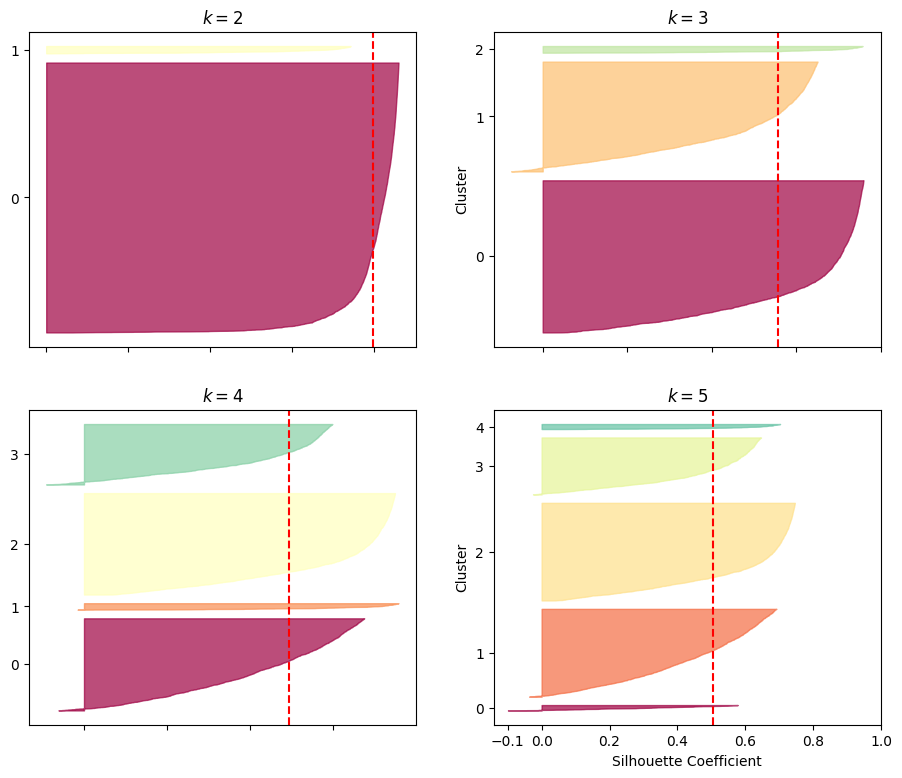

In [194]:
from matplotlib.ticker import FixedLocator, FixedFormatter
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(image_data_pca_2, y_pred)

    padding = len(image_data_pca_2) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")

    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

Scatter plot with potential optimal values below

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


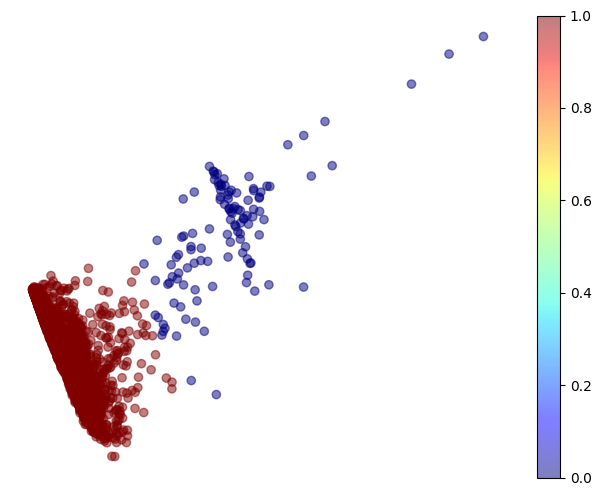

In [139]:
#plot a 2d cluster
optimal_k = 2
kmeans1 = KMeans(n_clusters=optimal_k, init="random", random_state=42)
clusters = kmeans1.fit_predict(image_data_pca_2)

plt.figure(figsize=(8, 6))
plt.scatter(image_data_pca_2[:,0], image_data_pca_2[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


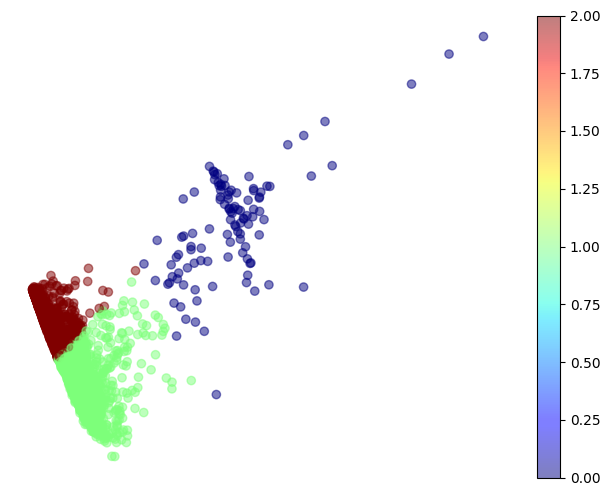

In [148]:
#plot a 2d cluster
optimal_k = 3
kmeans2 = KMeans(n_clusters=optimal_k, init="random", random_state=42)
clusters = kmeans2.fit_predict(image_data_pca_2)

plt.figure(figsize=(8, 6))
plt.scatter(image_data_pca_2[:,0], image_data_pca_2[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

#### Observations:

From the above visualisations :\
There seems to be a clear demarkation when the number of cluster = 2.

Hence choosing the optimal k = 2

Will be running K-means for both k=2, k=3

This is kind of absurd as the total number of categories is 8 but the optimal after dimensionality reduction is 2, this could result due to some overlapping features among the categories.

### Q5.B
### a. Visualization: Boundaries can be inferred with centroids of each cluster
### b. Dots are color mapped according to labels

In [143]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, labels, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.scatter(X[:, 0], X[:, 1], c=[label for label in labels], cmap='viridis', edgecolors='k', marker='o', s=50, alpha=0.7)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

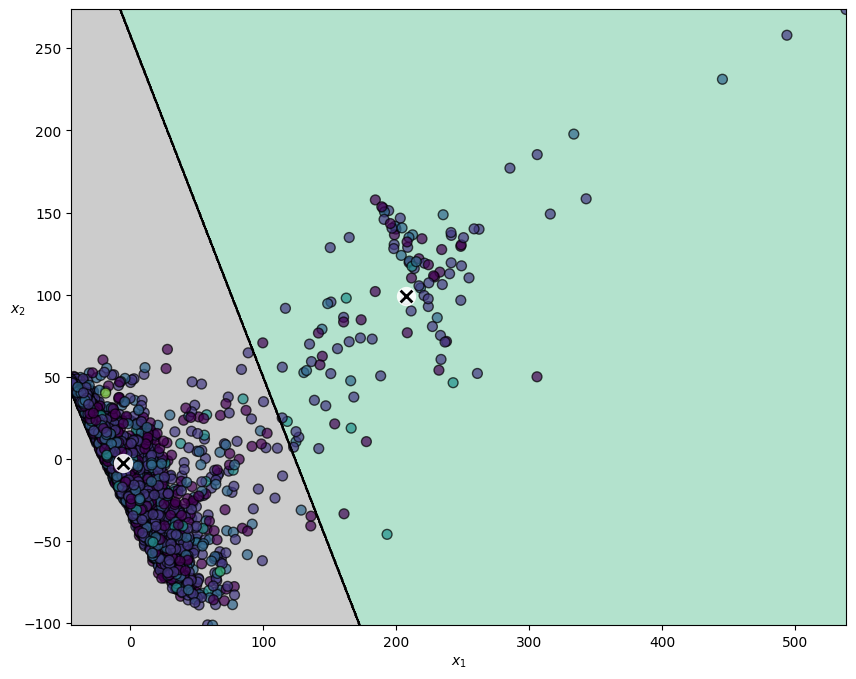

In [144]:
plt.figure(figsize=(10, 8))
plot_decision_boundaries(kmeans1, labels, image_data_pca_2)
plt.show()

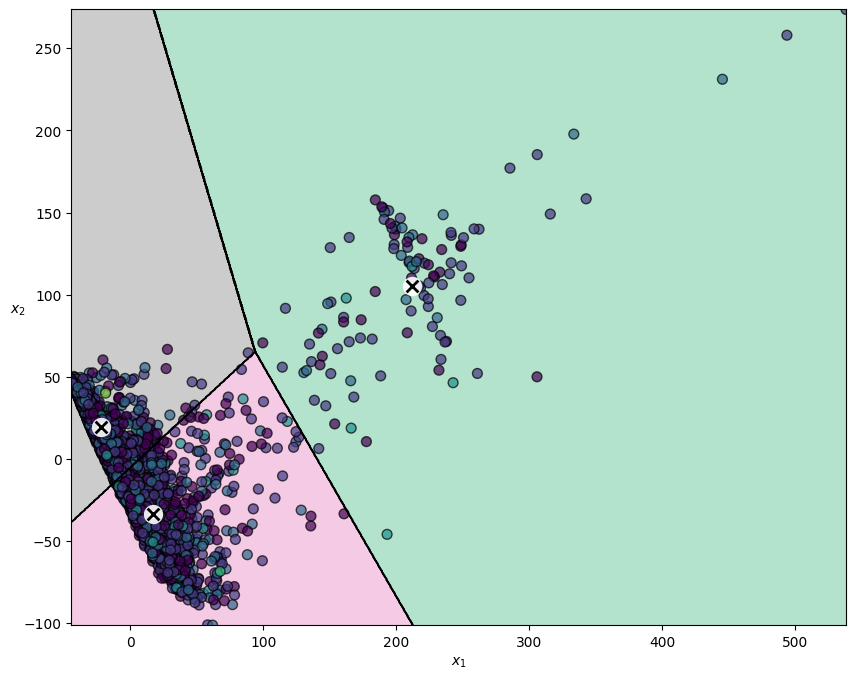

In [149]:
plt.figure(figsize=(10, 8))
plot_decision_boundaries(kmeans2, labels, image_data_pca_2)
plt.show()

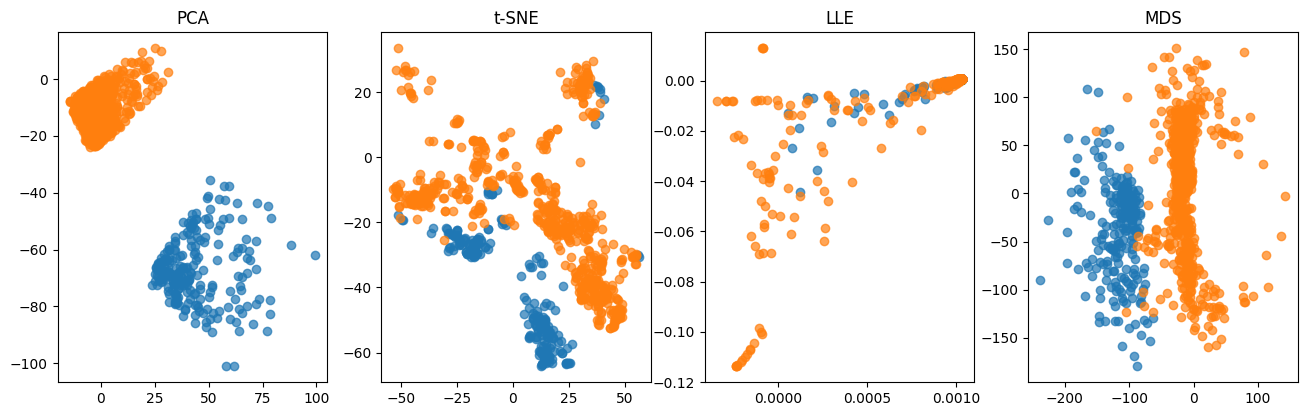

In [197]:
# Visualize the results
plt.figure(figsize=(16, 10))
num_clusters = 2

# PCA
plt.subplot(2, 4, 1)
for i in range(num_clusters):
    indices = np.where(cluster_labels == i)
    plt.scatter(image_data_pca_2[indices, 0], image_data_pca_2[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('PCA')

# t-SNE
plt.subplot(2, 4, 2)
for i in range(num_clusters):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_tsne[indices, 0], images_2d_tsne[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('t-SNE')

# LLE
plt.subplot(2, 4, 3)
for i in range(num_clusters):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_lle[indices, 0], images_2d_lle[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('LLE')

# MDS
plt.subplot(2, 4, 4)
for i in range(num_clusters):
    indices = np.where(cluster_labels == i)
    plt.scatter(images_2d_mds[indices, 0], images_2d_mds[indices, 1], label=f'Cluster {i}', alpha=0.7)
plt.title('MDS')

plt.show()


## Expectation Maximisation

### Q6.A
### a. EM has been implemented correctly
### b. Evaluation of the number of clusters.

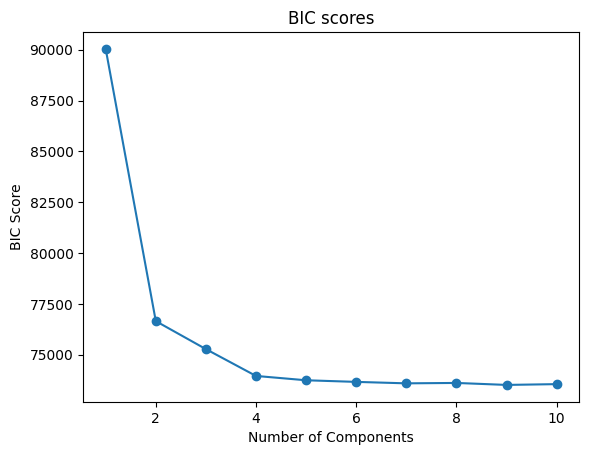

In [154]:
# Q6.A
# a. EM has been implemented correctly
# b. Evaluation of the number of clusters.


from sklearn.mixture import GaussianMixture

bic_scores = []
max_components = 10

for i in range(1, max_components + 1):
    gmm = GaussianMixture(n_components=i, random_state=42)
    gmm.fit(image_data_pca_2)
    bic_scores.append(gmm.bic(image_data_pca_2))

plt.plot(range(1, max_components + 1), bic_scores, marker='o')
plt.title('BIC scores')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.show()

Upon applying the Bayesian Information Criterion (BIC) to the Expectation-Maximization (EM) algorithm with Principal Component Analysis (PCA) dimensionality reduction, we observed that the BIC scores were minimized when the number of clusters = 4 after which the BIC got saturated for the subsequent number of clusters. This implies that, based on the balance between model fit and complexity, the most suitable configuration for clustering was achieved with 4 clusters.

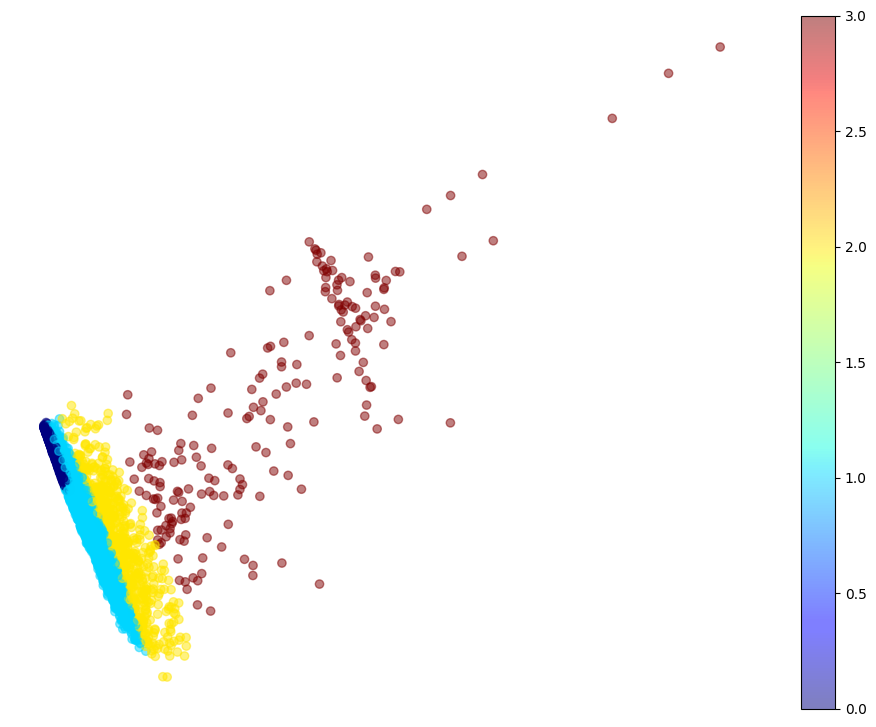

In [199]:
optimal_components = 4  

gmm1 = GaussianMixture(n_components=optimal_components, random_state=42)
clusters = gmm1.fit_predict(image_data_pca_2)

plt.figure(figsize=(12, 9))
plt.scatter(image_data_pca_2[:,0], image_data_pca_2[:, 1],
            c=clusters, cmap="jet", alpha=0.5)
plt.axis('off')
plt.colorbar()
plt.show()

### Q6.B
### a. Visualization: Boundaries can be inferred with centroids of each cluster
### b. Dots are color mapped according to labels

In [156]:
# Q6.B
# a. Visualization: Boundaries can be inferred with centroids of each cluster
# b. Dots are color mapped according to labels

from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, labels, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], c=[label for label in labels], cmap='viridis', edgecolors='k', marker='o', s=50, alpha=0.7)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

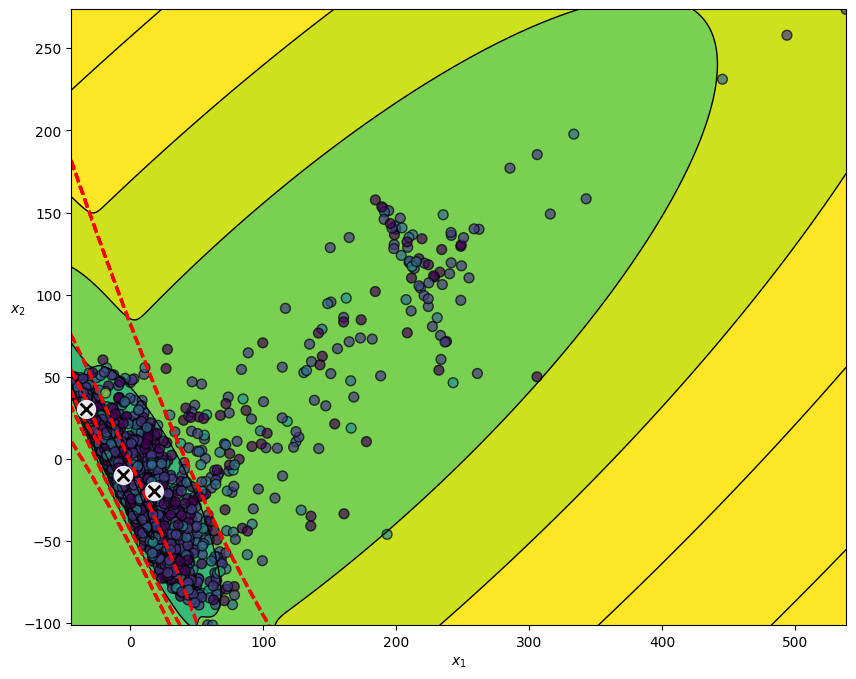

In [157]:
plt.figure(figsize=(10, 8))
plot_gaussian_mixture(gmm1,image_data_pca_2,labels)
plt.show()

### Q6.C
### Generation of 20 rock images using sample method with visualization 

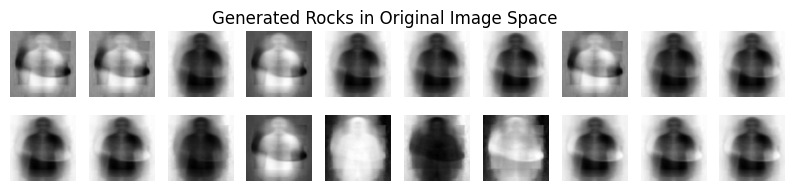

In [159]:
# Q6.C
# Generation of 20 rock images using sample method with visualization 

new_samples, _ = gmm.sample(20)

# Use PCA's inverse_transform to map the samples back to the original space
original_space_samples = pca_2.inverse_transform(new_samples)

def plot_images(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(images.shape[0]):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Assuming 'image_shape' is the shape of your original images
image_shape = (100, 100, 1)

plot_images(original_space_samples, title='Generated Products in Original Image Space')

# Neural Net

In [2]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

2023-11-17 21:23:14.358719: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Loading the images 

def load_images_NN(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (400, 400))
            images.append(img)
    return np.array(images), np.array(label_category)

In [21]:
import os
import cv2
import numpy as np

# Splitting into test, train data set.

from sklearn.model_selection import train_test_split

X, y = load_images_NN('archive/images_subsampled_gray')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_val.shape)

Shape of X_train: (3527, 400, 400, 3)
Shape of X_test: (882, 400, 400, 3)
Shape of y_train: (3527,)
Shape of y_test: (882,)


In [173]:
from PIL import Image
import numpy as np

image_path = 'archive/images_subsampled_gray/gray_59936.jpg'
img = Image.open(image_path)
img_array = np.array(img)
max_pixel_value = np.max(img_array)

print(f"The maximum pixel value in the image is: {max_pixel_value}")

The maximum pixel value in the image is: 255


In [ ]:
# scaling it btw 0-1, we divide it by 255 as its the max value for a pixel
X_train = X_train / 255.0
X_val = X_val / 255.0

In [174]:
# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# convert to one_hot
y_train_one_hot = to_categorical(y_train_encoded, num_classes=8)
y_val_one_hot = to_categorical(y_val_encoded, num_classes=8)

In [178]:
#define height,width and channel
height,width,channels=400,400,3

### Q7. B
### a. Sequential Model has been implemented correctly with right number of neurons

In [189]:
# Q7. B
# a. Sequential Model has been implemented correctly with right number of neurons

# neural network model
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv2D(25, (3, 3), activation='relu', input_shape=(400, 400, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(50, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten(input_shape=(height, width, channels)))
model.add(layers.Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(25, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(layers.Dense(8, activation='softmax'))

The simple feedforward neural network has

1. The first convolutional layer with 25 filters, each of size (3, 3), and ReLU activation function. It takes input images of shape (400, 400, 3). The MaxPooling layer with a pool size of (2, 2) follows, reducing spatial dimensions.
2. A second convolutional layer with 50 filters and ReLU activation, followed by another MaxPooling layer.
3. One Flatten layer
4. Three hidden Dense layers with ReLU activation with l2 regularization
5. Output Dense layer with softmax activation for multi-class classification. Output layer with 8 neurons.

### Q7.A
### Training Time has been Reported

In [190]:
# Q7.A
# Training Time has been Reported

start_time = time.time()

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_one_hot,
                    validation_data=(X_val, y_val_one_hot),
                    epochs=10, batch_size=32)
# Record the end time
end_time = time.time()

Epoch 1/10
111/111 [==============================] - 349s 3s/step - loss: 182.8712 - accuracy: 0.3371 - val_loss: 30.5581 - val_accuracy: 0.4705
Epoch 2/10
111/111 [==============================] - 337s 3s/step - loss: 25.8147 - accuracy: 0.4511 - val_loss: 21.8391 - val_accuracy: 0.4524
Epoch 3/10
111/111 [==============================] - 1562s 14s/step - loss: 19.4533 - accuracy: 0.4565 - val_loss: 17.0835 - val_accuracy: 0.4739
Epoch 4/10
111/111 [==============================] - 340s 3s/step - loss: 15.3983 - accuracy: 0.4721 - val_loss: 13.8209 - val_accuracy: 0.4683
Epoch 5/10
111/111 [==============================] - 331s 3s/step - loss: 12.4930 - accuracy: 0.4752 - val_loss: 11.2821 - val_accuracy: 0.4683
Epoch 6/10
111/111 [==============================] - 323s 3s/step - loss: 10.3607 - accuracy: 0.4837 - val_loss: 9.4702 - val_accuracy: 0.4751
Epoch 7/10
111/111 [==============================] - 328s 3s/step - loss: 8.7159 - accuracy: 0.4848 - val_loss: 8.0420 - val_ac

In [191]:
# Calculate and print the training time
training_time_seconds = end_time - start_time
print(f"Training time: {training_time_seconds} seconds")

Training time: 4520.361469984055 seconds


### Q7.B
### a. Validation Data has been incorporated
### b. Accuracy is increasing with epochs
### c. Plots of val and training loss via training epochs

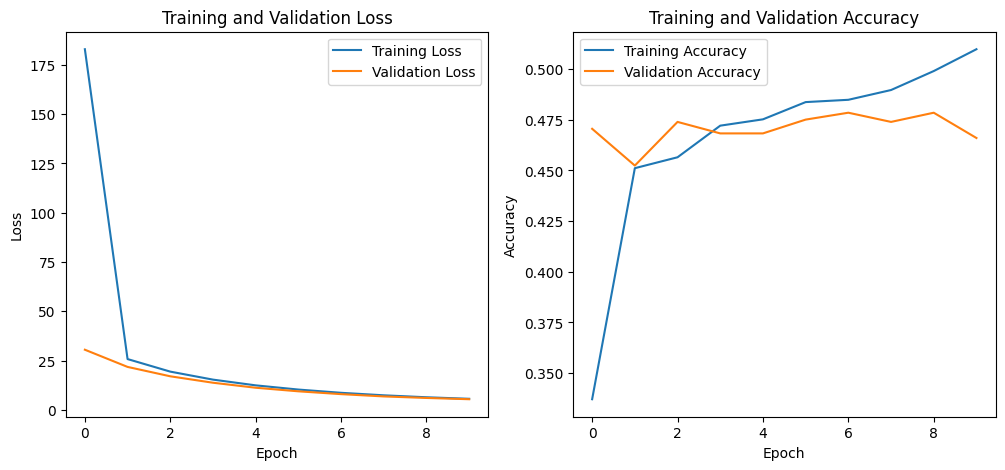

In [192]:
# Q7.B
# a. Validation Data has been incorporated
# b. Accuracy is increasing with epochs
# c. Plots of val and training loss via training epochs

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Here we can see that the validation dataset has been incorporated.\
Also the training accuracy increases with each epoch

### Q7.C
### a. Total Number of parameters
### b. Total Number of bias parameters 

In [200]:
# Q7.C
# a. Total Number of parameters
# b. Total Number of bias parameters 

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 398, 398, 25)      700       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 199, 199, 25)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 197, 197, 50)      11300     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 98, 98, 50)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 480200)            0         
                                                                 
 dense_16 (Dense)            (None, 100)              

Observation :\
Total number of parameters : 48038633\
Total number of bias parameters : (25 + 50) + (100 + 50 + 25 + 8) = 258